---
---
### Lista de encabezados
1. Piezas del Vehículo:
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura maletro",
    28: "Moldura puerta delantera derecha",
    29: "Moldura puerta delantera izquierda",
    30: "Moldura puerta trasera derecha",
    31: "Moldura puerta trasera izquierda",
    32: "Parabrisas delantero",
    33: "Parabrisas trasero",
    34: "Parachoques delantero",
    35: "Parachoques trasero",
    36: "Puerta delantera derecha",
    37: "Puerta delantera izquierda",
    38: "Puerta trasera derecha",
    39: "Puerta trasera izquierda",
    40: "Rejilla, parrilla",
    41: "Rueda",
    42: "Tapa de combustible",
    43: "Tapa de rueda",
    44: "Techo",
    45: "Techo corredizo",
    46: "Ventana delantera derecha",
    47: "Ventana delantera izquierda",
    48: "Ventana trasera derecha",
    49: "Ventana trasera izquierda",
    50: "Ventanilla delantera derecha",
    51: "Ventanilla delantera izquierda",
    52: "Ventanilla trasera derecha",
    53: "Ventanilla trasera izquierda"

2. Tipos de Daño:
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"

3. Sugerencia:
    1:"Reparar", 
    2:"Reemplazar"

In [1]:
# =============================================
# IMPORTS
# =============================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import Counter
from tqdm import tqdm
import ast
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from sklearn.preprocessing import MultiLabelBinarizer

# =============================================
# CONFIGURACIÓN MEJORADA
# =============================================
# Configuración adicional
CLASS_WEIGHTS = True  
FOCAL_LOSS = True     
AUGMENTATION = True   
EARLY_STOPPING = True 
USE_TENSORBOARD = True

# Hiperparámetros optimizados
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_EPOCHS = 150  # Aumentado para permitir más aprendizaje
MIN_SAMPLES_PER_CLASS = 20
LR = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 20  # Aumentada para early stopping

# Variables para guarda las métricas para graficar
train_loss_history = []
val_metric_history = []

In [2]:
try:
    from torch.utils.tensorboard import SummaryWriter
    print("¡TensorBoard importado correctamente!")
    writer = SummaryWriter()
    writer.add_scalar('test', 1.0, 1)
    writer.close()
    print("Prueba de escritura en TensorBoard completada")
except Exception as e:
    print(f"Error: {str(e)}")

¡TensorBoard importado correctamente!
Prueba de escritura en TensorBoard completada


In [3]:
# =============================================
# 1. DICCIONARIOS COMPLETOS DE MAPEO (CORREGIDOS)
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

# Diccionario para Tipos de Daño (completo)
label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

# Diccionario para Sugerencia (completo)
label_to_cls_sugerencia = {
    1: "Reparar",
    2: "Reemplazar"
}

In [4]:
# =============================================
# Cargar los datasets
# =============================================
multi_train = pd.read_csv('data/fotos_siniestros/datasets/multi_train.csv', sep='|')
multi_val = pd.read_csv('data/fotos_siniestros/datasets/multi_val.csv', sep='|')
multi_test = pd.read_csv('data/fotos_siniestros/datasets/multi_test.csv', sep='|')

In [5]:
# =============================================
# Convertir string a lista
# =============================================
def convert_string_lists(df):
    # Aplicar literal_eval a las columnas relevantes
    df['partes'] = df['partes'].apply(ast.literal_eval)
    df['dannos'] = df['dannos'].apply(ast.literal_eval)
    df['sugerencias'] = df['sugerencias'].apply(ast.literal_eval)
    return df

# Aplicar a todos tus datasets
multi_train = convert_string_lists(multi_train)
multi_val = convert_string_lists(multi_val)
multi_test = convert_string_lists(multi_test)

# Rename columns to match dataset class expectations
multi_train = multi_train[['Imagen', 'dannos', 'partes', 'sugerencias']].rename(columns={
    'dannos': 'damages',
    'partes': 'parts',
    'sugerencias': 'suggestions'
})

# Rename columns to match dataset class expectations
multi_val = multi_val[['Imagen', 'dannos', 'partes', 'sugerencias']].rename(columns={
    'dannos': 'damages',
    'partes': 'parts',
    'sugerencias': 'suggestions'
})

multi_test = multi_test[['Imagen', 'dannos', 'partes', 'sugerencias']].rename(columns={
    'dannos': 'damages',
    'partes': 'parts',
    'sugerencias': 'suggestions'
})

In [6]:
print(multi_train.head())
print(multi_val.head())
print(multi_test.head())

    Imagen       damages            parts   suggestions
0  563.jpg           [6]             [31]           [2]
1  746.jpg  [1, 2, 2, 6]  [12, 33, 3, 10]  [1, 2, 1, 2]
2  404.jpg        [1, 1]         [14, 38]        [1, 1]
3  295.jpg           [5]             [33]           [1]
4  817.jpg        [5, 5]         [33, 11]        [1, 1]
    Imagen damages     parts suggestions
0  130.jpg  [1, 1]  [36, 25]      [1, 1]
1  437.jpg     [2]      [11]         [1]
2  212.jpg     [6]      [47]         [2]
3  338.jpg  [1, 2]  [25, 35]      [1, 1]
4  326.jpg  [5, 6]  [13, 19]      [1, 2]
    Imagen    damages        parts suggestions
0  550.jpg        [4]         [34]         [1]
1  469.jpg        [6]         [31]         [2]
2  427.jpg        [5]         [12]         [1]
3  842.jpg  [1, 1, 6]  [3, 43, 31]   [1, 1, 2]
4  403.jpg     [1, 1]     [14, 38]      [1, 1]


In [7]:
# =============================================
# MODELO
# =============================================
class MultiLabelDamageClassifier(nn.Module):
    def __init__(self, num_parts, num_damages, num_suggestions):
        super().__init__()
        
        # Capa base (ResNet50 pre-entrenada)
        self.base_model = models.resnet50(pretrained=True)
        
        # Congelar capas base inicialmente
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Ajustar la última capa para nuestras tareas
        num_features = self.base_model.fc.in_features
        
        # Cabezas de clasificación mejoradas
        self.parts_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_parts)
        )
        
        self.damages_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_damages)
        )
        
        self.suggestions_head = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_suggestions)
        )
        
        # Inicialización mejorada
        for head in [self.parts_head, self.damages_head, self.suggestions_head]:
            for m in head.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.base_model.conv1(x)
        features = self.base_model.bn1(features)
        features = self.base_model.relu(features)
        features = self.base_model.maxpool(features)
        
        features = self.base_model.layer1(features)
        features = self.base_model.layer2(features)
        features = self.base_model.layer3(features)
        features = self.base_model.layer4(features)
        
        features = self.base_model.avgpool(features)
        features = torch.flatten(features, 1)
        
        return {
            'parts': self.parts_head(features),
            'damages': self.damages_head(features),
            'suggestions': self.suggestions_head(features)
        }

    def unfreeze_layers(self, num_layers=3):
        """Descongela capas para fine-tuning"""
        for name, param in self.base_model.named_parameters():
            if any(f'layer4.{i}.' in name for i in range(4)[-num_layers:]):
                param.requires_grad = True

In [8]:
# =============================================
# DATASET
# =============================================
class BalancedMultiLabelDamageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform
        
        # Convertir strings a listas
        for col in ['parts', 'damages', 'suggestions']:
            self.data[col] = self.data[col].apply(
                lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        
        # Mapeo de clases
        self.part_to_idx = {part: idx for idx, part in label_to_cls_piezas.items()}
        self.damage_to_idx = {damage: idx for idx, damage in label_to_cls_danos.items()}
        self.suggestion_to_idx = {sug: idx for idx, sug in label_to_cls_sugerencia.items()}
        
        # Binarizadores mejorados
        self.part_binarizer = MultiLabelBinarizer(classes=sorted(self.part_to_idx.values()))
        self.damage_binarizer = MultiLabelBinarizer(classes=sorted(self.damage_to_idx.values()))
        self.suggestion_binarizer = MultiLabelBinarizer(classes=sorted(self.suggestion_to_idx.values()))
        
        # Calcular pesos mejorados
        self.part_weights = self._calculate_weights('part')
        self.damage_weights = self._calculate_weights('damage')
        self.suggestion_weights = self._calculate_weights('suggestion')

    def _calculate_weights(self, task):
        """Versión mejorada con square root inverse frequency"""
        all_labels = [label for labels in self.data[f'{task}s'] 
                     for label in labels if label in getattr(self, f'{task}_to_idx')]
        
        if not all_labels:
            return torch.ones(len(getattr(self, f'{task}_to_idx')), dtype=torch.float32).to(DEVICE)
        
        counts = Counter(all_labels)
        total = len(all_labels)
        weights = {cls: 1/np.sqrt(count/total) for cls, count in counts.items()}
        
        # Peso mínimo de 1.0 para clases no presentes
        return torch.tensor([weights.get(cls, 1.0) for cls in sorted(getattr(self, f'{task}_to_idx').values())], 
                          dtype=torch.float32).to(DEVICE)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = ""  # Inicializamos la variable
        
        try:
            # Verificamos que el índice sea válido
            if idx >= len(self.data):
                raise IndexError(f"Índice {idx} fuera de rango (tamaño del dataset: {len(self.data)})")
                
            img_path = os.path.join(self.img_dir, self.data.iloc[idx]['Imagen'])
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error al cargar imagen (índice {idx}): {str(e)}")
            if not img_path:  # Si no se pudo obtener la ruta
                img_path = f"Índice inválido: {idx}"
            print(f"Ruta problemática: {img_path}")
            image = torch.zeros(3, 224, 224)  # Imagen dummy
        
        # Resto del código para procesar etiquetas...
        parts = torch.zeros(len(self.part_to_idx))
        for part in self.data.iloc[idx]['parts']:
            if part in self.part_to_idx:
                parts[self.part_to_idx[part]] = 1
                
        damages = torch.zeros(len(self.damage_to_idx))
        for damage in self.data.iloc[idx]['damages']:
            if damage in self.damage_to_idx:
                damages[self.damage_to_idx[damage]] = 1
                
        suggestions = torch.zeros(len(self.suggestion_to_idx))
        for sug in self.data.iloc[idx]['suggestions']:
            if sug in self.suggestion_to_idx:
                suggestions[self.suggestion_to_idx[sug]] = 1

        if self.transform:
            image = self.transform(image)
            
        return image, {
            'parts': parts,
            'damages': damages,
            'suggestions': suggestions
        }

In [9]:
# =============================================
# DATA AUGMENTATION
# =============================================
def get_transforms():
    # Transformaciones base
    base_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    if AUGMENTATION:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.RandomRotation(15),
            transforms.RandomAffine(0, shear=15),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        train_transform = base_transform
        
    return {
        'train': train_transform,
        'val': base_transform,
        'test': base_transform
    }

In [10]:
# =============================================
# EARLY STOPPING
# =============================================
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [11]:
# =============================================
# Recolecta las imagenes
# =============================================
def collate_fn(batch):
    # Filtrar None (imágenes que fallaron al cargar)
    batch = [b for b in batch if b is not None]
    
    # Si todo el batch falló, retornar un batch dummy
    if len(batch) == 0:
        dummy_image = torch.zeros(3, 224, 224)
        dummy_target = {
            'parts': torch.zeros(len(label_to_cls_piezas)),
            'damages': torch.zeros(len(label_to_cls_danos)),
            'suggestions': torch.zeros(len(label_to_cls_sugerencia))
        }
        return dummy_image.unsqueeze(0), dummy_target
    
    # Procesamiento normal
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    images = torch.stack(images, dim=0)
    
    batch_targets = {
        'parts': torch.stack([t['parts'] for t in targets], dim=0),
        'damages': torch.stack([t['damages'] for t in targets], dim=0),
        'suggestions': torch.stack([t['suggestions'] for t in targets], dim=0)
    }

    return images, batch_targets

In [12]:
# =============================================
# Evalua las metricas
# =============================================
def evaluate_multi_label(model, data_loader):
    """Evalúa el modelo en el conjunto de validación/test"""
    model.eval()
    parts_preds = []
    parts_targets = []
    damages_preds = []
    damages_targets = []
    suggestions_preds = []
    suggestions_targets = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            
            # Guardar predicciones y targets para cada tarea
            parts_preds.append(torch.sigmoid(outputs['parts']).cpu())
            parts_targets.append(targets['parts'].cpu())
            
            damages_preds.append(torch.sigmoid(outputs['damages']).cpu())
            damages_targets.append(targets['damages'].cpu())
            
            suggestions_preds.append(torch.softmax(outputs['suggestions'], dim=1).cpu())
            suggestions_targets.append(targets['suggestions'].cpu())
    
    # Concatenar todos los batches
    parts_preds = torch.cat(parts_preds)
    parts_targets = torch.cat(parts_targets)
    damages_preds = torch.cat(damages_preds)
    damages_targets = torch.cat(damages_targets)
    suggestions_preds = torch.cat(suggestions_preds)
    suggestions_targets = torch.cat(suggestions_targets)
    
    # Calcular métricas para cada tarea
    def calculate_metrics(preds, targets, task_type='multilabel'):
        if task_type == 'multilabel':
            # Para partes y daños (clasificación multi-etiqueta)
            preds = (preds > 0.5).float()  # Umbral de 0.5
            accuracy = accuracy_score(targets, preds)
            f1 = f1_score(targets, preds, average='macro')
        else:
            # Para sugerencias (clasificación multi-clase)
            preds = preds.argmax(dim=1)
            targets = targets.argmax(dim=1)
            accuracy = accuracy_score(targets, preds)
            f1 = f1_score(targets, preds, average='macro')
        
        return {'accuracy': accuracy, 'f1_macro': f1}
    
    metrics = {
        'parts': calculate_metrics(parts_preds, parts_targets, 'multilabel'),
        'damages': calculate_metrics(damages_preds, damages_targets, 'multilabel'),
        'suggestions': calculate_metrics(suggestions_preds, suggestions_targets, 'multiclass')
    }
    
    return metrics

In [13]:
# =============================================
# FUNCIONES DE PÉRDIDA
# =============================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets, weights=None):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if weights is not None:
            # Aplicar pesos por clase
            class_weights = weights.expand_as(targets)
            F_loss = F_loss * class_weights
            
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        return F_loss

def balanced_multi_label_loss(outputs, targets, weights):
    # Configuración mejorada de pérdidas
    parts_loss_fn = FocalLoss(alpha=0.25, gamma=2.0) if FOCAL_LOSS else nn.BCEWithLogitsLoss()
    damages_loss_fn = FocalLoss(alpha=0.5, gamma=2.0) if FOCAL_LOSS else nn.BCEWithLogitsLoss()
    
    # Pérdidas con pesos
    parts_loss = parts_loss_fn(
        outputs['parts'], 
        targets['parts'].float(),
        weights=weights['parts'] if CLASS_WEIGHTS else None
    )
    
    damages_loss = damages_loss_fn(
        outputs['damages'], 
        targets['damages'].float(),
        weights=weights['damages'] if CLASS_WEIGHTS else None
    )
    
    # Sugerencias con label smoothing
    suggestions_loss = F.cross_entropy(
        outputs['suggestions'],
        targets['suggestions'].argmax(dim=1),
        weight=weights['suggestions'] if CLASS_WEIGHTS else None,
        label_smoothing=0.1
    )
    
    return 0.4 * parts_loss + 0.4 * damages_loss + 0.2 * suggestions_loss

In [14]:
# =============================================
# ENTRENAMIENTO
# =============================================
def train_model():
    # Inicializar TensorBoard
    writer = SummaryWriter() if USE_TENSORBOARD else None
    
    # Cargar transforms
    data_transforms = get_transforms()
    
    # Crear datasets
    train_dataset = BalancedMultiLabelDamageDataset(multi_train, '../data/fotos_siniestros/', data_transforms['train'])
    val_dataset = BalancedMultiLabelDamageDataset(multi_val, '../data/fotos_siniestros/', data_transforms['val'])
    
    # Sampler mejorado
    def get_sampler(dataset):
        """Sampler que considera múltiples tareas"""
        labels = []
        for idx in range(len(dataset)):
            # Combinar etiquetas de partes y daños para balanceo
            combined = tuple(dataset[idx][1]['parts'].nonzero().flatten().tolist() + 
                           dataset[idx][1]['damages'].nonzero().flatten().tolist())
            labels.append(combined)
        
        class_counts = Counter(labels)
        class_weights = {cls: 1./count for cls, count in class_counts.items()}
        sample_weights = [class_weights[cls] for cls in labels]
        
        return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    
    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=get_sampler(train_dataset),
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )
    
    # Modelo
    model = MultiLabelDamageClassifier(
        num_parts=len(label_to_cls_piezas),
        num_damages=len(label_to_cls_danos),
        num_suggestions=len(label_to_cls_sugerencia)
    ).to(DEVICE)
    
    # Optimizador y scheduler mejorados
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=LR*10, 
        epochs=NUM_EPOCHS, 
        steps_per_epoch=len(train_loader),
        pct_start=0.1
    )
    
    # Early Stopping mejorado
    early_stopper = EarlyStopping(patience=PATIENCE, delta=0.001) if EARLY_STOPPING else None
    
    # Entrenamiento
    best_metric = -float('inf')
    for epoch in range(NUM_EPOCHS):
        # Fine-tuning después de 20 épocas
        if epoch == 20:
            model.unfreeze_layers(2)
        
        # Fase de entrenamiento
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}', leave=False)
        
        for inputs, targets in progress_bar:
            inputs = inputs.to(DEVICE, non_blocking=True)
            targets = {k: v.to(DEVICE, non_blocking=True) for k, v in targets.items()}
            
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            
            loss = balanced_multi_label_loss(outputs, targets, {
                'parts': train_dataset.part_weights,
                'damages': train_dataset.damage_weights,
                'suggestions': train_dataset.suggestion_weights
            })
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        # Validación
        val_metrics = evaluate_multi_label(model, val_loader)
        current_metric = 0.4*val_metrics['parts']['f1_macro'] + 0.4*val_metrics['damages']['f1_macro'] + 0.2*val_metrics['suggestions']['f1_macro']
        
        # Early Stopping
        if EARLY_STOPPING:
            early_stopper(current_metric)
            if early_stopper.early_stop:
                print(f"\nEarly stopping at epoch {epoch+1} with metric {current_metric:.4f}")
                break
        
        # Guardar mejor modelo
        if current_metric > best_metric:
            best_metric = current_metric
            torch.save(model.state_dict(), 'best_model_multilabel.pth')
            print(f"\nNew best model saved with metric {best_metric:.4f}!")
        
        # Logging mejorado
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {epoch_loss/len(train_loader):.4f}")
        print(f"Validation Metric: {current_metric:.4f} (Best: {best_metric:.4f})")
        print("Detailed Metrics:")
        for task, metrics in val_metrics.items():
            print(f"  {task:12} - Acc: {metrics['accuracy']:.4f} | F1: {metrics['f1_macro']:.4f}")
        
        # TensorBoard logging
        if writer:
            writer.add_scalar('Loss/train', epoch_loss/len(train_loader), epoch)
            writer.add_scalar('Metric/val', current_metric, epoch)
            for task, metrics in val_metrics.items():
                writer.add_scalar(f'Accuracy/{task}', metrics['accuracy'], epoch)
                writer.add_scalar(f'F1/{task}', metrics['f1_macro'], epoch)

        # Guardas las métricas para graficar
        train_loss_history.append(epoch_loss/len(train_loader))
        val_metric_history.append(val_metrics)
    
    if writer:
        writer.close()
    
    return model

In [15]:
# =============================================
# Verificar que todas las imágenes sean accesibles
# =============================================
def verify_dataset(dataset):
    problematic_indices = []
    for i in tqdm(range(len(dataset))):
        try:
            img, targets = dataset[i]
            if torch.all(img == 0):  # Imagen dummy
                problematic_indices.append(i)
        except Exception as e:
            problematic_indices.append(i)
    
    if problematic_indices:
        print(f"\n¡Advertencia! {len(problematic_indices)} imágenes problemáticas encontradas")
        print("Primeros 10 índices problemáticos:", problematic_indices[:10])
    else:
        print("\n¡Dataset verificado correctamente!")

In [16]:
# Load transforms
data_transforms = get_transforms()

# Create datasets
train_dataset = BalancedMultiLabelDamageDataset(multi_train, '../data/fotos_siniestros/', data_transforms['train'])
val_dataset = BalancedMultiLabelDamageDataset(multi_val, '../data/fotos_siniestros/', data_transforms['val'])
test_dataset = BalancedMultiLabelDamageDataset(multi_test, '../data/fotos_siniestros/', data_transforms['test'])

# Verify datasets
print("Verifying validation dataset:")
verify_dataset(train_dataset)

print("Verifying validation dataset:")
verify_dataset(val_dataset)

print("Verifying test dataset:")
verify_dataset(test_dataset)

Verifying validation dataset:


100%|██████████| 629/629 [00:18<00:00, 33.77it/s]



¡Dataset verificado correctamente!
Verifying validation dataset:


100%|██████████| 287/287 [00:07<00:00, 40.77it/s]



¡Dataset verificado correctamente!
Verifying test dataset:


100%|██████████| 229/229 [00:07<00:00, 32.70it/s]


¡Dataset verificado correctamente!


In [ ]:
# Ejecutar entrenamiento

# New best model saved with metric 0.0383!

# Epoch 1/150
# Train Loss: 1.7380
# Validation Metric: 0.0383 (Best: 0.0383)
# Detailed Metrics:
#   parts        - Acc: 0.0000 | F1: 0.0000
#   damages      - Acc: 0.0000 | F1: 0.0000
#   suggestions  - Acc: 0.2369 | F1: 0.1915

# Epoch 20/150
# Train Loss: 0.2313
# Validation Metric: 0.0986 (Best: 0.2000)
# Detailed Metrics:
#   parts        - Acc: 0.9895 | F1: 0.0000
#   damages      - Acc: 0.8711 | F1: 0.0000
#   suggestions  - Acc: 0.9721 | F1: 0.4929

# Early stopping at epoch 21 with metric 0.2000

# Last Execution 3:50:48 PM
# Execution Time 21m 9.7s
# Overhead Time 6m 11.8s
# Render Times
# VS Code Builtin Notebook Output Renderer 69ms

if __name__ == '__main__':
    trained_model = train_model()
    torch.save(trained_model.state_dict(), 'DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetas_V5.pth')

---
Probar el modelo entrenado

In [39]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_model(model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Carga el modelo entrenado"""
    model = MultiLabelDamageClassifier(
        num_parts=len(label_to_cls_piezas),
        num_damages=len(label_to_cls_danos),
        num_suggestions=len(label_to_cls_sugerencia)
    ).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def preprocess_image(image_path, transform=None):
    """Preprocesa una imagen para la inferencia"""
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Añade dimensión de batch

def predict(image_path, model, transform=None, threshold=0.25):  # threshold=0.5
    """Realiza predicciones sobre una imagen"""
    # Preprocesar imagen
    image_tensor = preprocess_image(image_path, transform).to(model.base_model.fc.weight.device)
    
    # Realizar predicción
    with torch.no_grad():
        outputs = model(image_tensor)
    
    # Procesar salidas
    predictions = {
        'parts': {},
        'damages': {},
        'suggestions': {}
    }
    
    # Partes del vehículo (multi-label)
    parts_probs = torch.sigmoid(outputs['parts']).squeeze()
    for idx, prob in enumerate(parts_probs):
        if prob > threshold:
            predictions['parts'][label_to_cls_piezas[idx+1]] = prob.item()
    
    # Daños (multi-label)
    damages_probs = torch.sigmoid(outputs['damages']).squeeze()
    for idx, prob in enumerate(damages_probs):
        if prob > threshold:
            predictions['damages'][label_to_cls_danos[idx+1]] = prob.item()
    
    # Sugerencias (multi-class)
    suggestion_probs = torch.softmax(outputs['suggestions'], dim=1).squeeze()
    suggestion_idx = torch.argmax(suggestion_probs).item()
    predictions['suggestions'][label_to_cls_sugerencia[suggestion_idx+1]] = suggestion_probs[suggestion_idx].item()
    
    return predictions

def display_prediction(image_path, prediction):
    """Muestra la imagen y las predicciones"""
    # Mostrar imagen
    img = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    
    # Crear texto con predicciones
    prediction_text = "Predicciones:\n\n"
    
    # Partes
    prediction_text += "Partes afectadas:\n"
    for part, prob in prediction['parts'].items():
        prediction_text += f"- {part}: {prob:.2f}\n"
    
    # Daños
    prediction_text += "\nTipos de daño:\n"
    for damage, prob in prediction['damages'].items():
        prediction_text += f"- {damage}: {prob:.2f}\n"
    
    # Sugerencias
    suggestion, prob = next(iter(prediction['suggestions'].items()))
    prediction_text += f"\nSugerencia: {suggestion} (confianza: {prob:.2f})"
    
    # Mostrar texto
    plt.figtext(0.5, 0.01, prediction_text, ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.7, "pad":5})
    plt.show()

In [40]:
# Ejemplo de uso
if __name__ == '__main__':
    # Cargar el modelo entrenado
    model = load_model('DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetas_V5.pth')

Resultados de la predicción:

Partes detectadas:
- Ventanilla trasera izquierda: 0.69

Daños detectados:

Sugerencia:
- Reparar (confianza: 1.00)


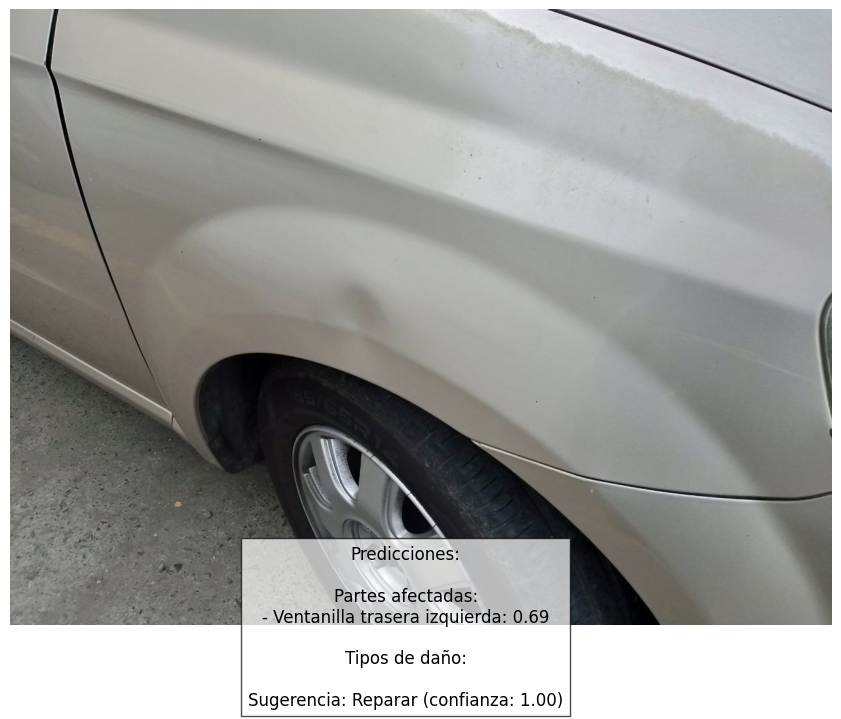

In [43]:
# Ruta a la imagen de prueba    Siniestro_02.jpg
# test_image_path = "../data/predecir/golpe_01.jpg"
# test_image_path = "../data/predecir/Siniestro_02.jpg"
test_image_path = "../data/predecir/Siniestro_01.jpg"

# Realizar predicción
prediction = predict(test_image_path, model)

# Mostrar resultados
print("Resultados de la predicción:")
print("\nPartes detectadas:")
for part, prob in prediction['parts'].items():
    print(f"- {part}: {prob:.2f}")

print("\nDaños detectados:")
for damage, prob in prediction['damages'].items():
    print(f"- {damage}: {prob:.2f}")

print("\nSugerencia:")
suggestion, prob = next(iter(prediction['suggestions'].items()))
print(f"- {suggestion} (confianza: {prob:.2f})")

# Mostrar imagen con predicciones (opcional)
display_prediction(test_image_path, prediction)

---

- Gráficos importantes adaptados a multi-etiqueta:

    1. Training History:
        - Evolución de la pérdida de entrenamiento
        - Evolución del F1-score para cada tarea en validación

    2. Confusion Matrices:
        - Matriz clásica para sugerencias (clasificación multi-clase)
        - Matrices por clase para partes y daños (clasificación multi-etiqueta)

    3. Class Distribution:
        - Distribución de clases en el dataset de entrenamiento
        - Para cada una de las tres tareas

    4. Sample Predictions:
        - Muestra imágenes con sus etiquetas verdaderas y predicciones
        - Útil para análisis cualitativo

In [17]:
# Cargar datasets y crear DataLoaders
data_transforms = get_transforms()
train_dataset = BalancedMultiLabelDamageDataset(multi_train, '../data/fotos_siniestros/', data_transforms['train'])
val_dataset = BalancedMultiLabelDamageDataset(multi_val, '../data/fotos_siniestros/', data_transforms['val'])

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4
)

# 2. Cargar el modelo
model = MultiLabelDamageClassifier(
    num_parts=len(label_to_cls_piezas),
    num_damages=len(label_to_cls_danos),
    num_suggestions=len(label_to_cls_sugerencia)
).to(DEVICE)

model.load_state_dict(torch.load('DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetas_V5.pth'))
model.eval()

/data/Python/VerificacionDeSiniestrosUsandoMultiplesEtiquetas/.venv/lib64/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/Python/VerificacionDeSiniestrosUsandoMultiplesEtiquetas/.venv/lib64/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiLabelDamageClassifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.utils import make_grid

def plot_training_history(train_losses, val_metrics):
    """Grafica la pérdida de entrenamiento y métricas de validación"""
    plt.figure(figsize=(12, 5))
    
    # Gráfico de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Gráfico de métricas
    plt.subplot(1, 2, 2)
    tasks = list(val_metrics[0].keys())
    for task in tasks:
        metric_values = [epoch[task]['f1_macro'] for epoch in val_metrics]
        plt.plot(metric_values, label=f'{task} F1')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('reportes/training_history.png')
    plt.show()

def plot_confusion_matrices(model, dataloader, class_maps):
    """Genera matrices de confusión para cada tarea"""
    model.eval()
    device = next(model.parameters()).device
    
    # Recolectar todas las predicciones y etiquetas verdaderas
    all_outputs = {'parts': [], 'damages': [], 'suggestions': []}
    all_targets = {'parts': [], 'damages': [], 'suggestions': []}
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            for task in ['parts', 'damages', 'suggestions']:
                if task == 'suggestions':
                    # Para sugerencias (clasificación multi-clase)
                    all_outputs[task].append(torch.softmax(outputs[task], dim=1).cpu().numpy())
                    all_targets[task].append(targets[task].cpu().numpy())
                else:
                    # Para partes y daños (clasificación multi-etiqueta)
                    all_outputs[task].append(torch.sigmoid(outputs[task]).cpu().numpy())
                    all_targets[task].append(targets[task].cpu().numpy())
    
    # Procesar cada tarea
    for task in ['parts', 'damages', 'suggestions']:
        outputs = np.concatenate(all_outputs[task])
        targets = np.concatenate(all_targets[task])
        
        if task == 'suggestions':
            # Matriz de confusión estándar para sugerencias
            y_true = np.argmax(targets, axis=1)
            y_pred = np.argmax(outputs, axis=1)
            cm = confusion_matrix(y_true, y_pred)
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_maps[task].values(),
                        yticklabels=class_maps[task].values())
            plt.title(f'Confusion Matrix - {task.capitalize()}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.savefig(f'reportes/confusion_matrix_{task}.png')
            plt.show()
        else:
            # Matrices de confusión multi-etiqueta para partes y daños
            y_true = targets
            y_pred = (outputs > 0.5).astype(int)  # Umbral de 0.5
            
            # Matriz de confusión por clase
            mcm = multilabel_confusion_matrix(y_true, y_pred)
            class_names = list(class_maps[task].values())
            
            plt.figure(figsize=(12, 8))
            for i, (cm, name) in enumerate(zip(mcm, class_names)):
                plt.subplot(int(np.ceil(len(class_names)/3)), 3, i+1)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                            xticklabels=['Neg', 'Pos'], 
                            yticklabels=['Neg', 'Pos'])
                plt.title(f'Class: {name}')
                plt.ylabel('True')
                plt.xlabel('Predicted')
            
            plt.suptitle(f'Multi-Label Confusion Matrices - {task.capitalize()}')
            plt.tight_layout()
            plt.savefig(f'reportes/multilabel_confusion_{task}.png')
            plt.show()

def plot_class_distribution(dataset, class_maps):
    """Visualiza la distribución de clases en el dataset"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, task in enumerate(['parts', 'damages', 'suggestions']):
        # Contar ocurrencias de cada clase
        counts = Counter()
        for sample in dataset:
            labels = sample[1][task].nonzero().flatten().tolist()
            counts.update(labels)
        
        # Ordenar por índice de clase
        sorted_counts = {k: counts[k] for k in sorted(counts)}
        class_names = [class_maps[task][idx+1] for idx in sorted_counts.keys()]
        
        # Gráfico de barras
        ax = axes[i]
        bars = ax.bar(class_names, sorted_counts.values())
        ax.set_title(f'Class Distribution - {task.capitalize()}')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=90)
        
        # Añadir valores en las barras
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('reportes/class_distribution.png')
    plt.show()

In [ ]:
def plot_sample_predictions(model, dataset, num_samples=5):
    """Muestra predicciones de ejemplo con imágenes"""
    model.eval()
    device = next(model.parameters()).device
    
    # Seleccionar muestras aleatorias
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    plt.figure(figsize=(15, 3*num_samples))
    for i, idx in enumerate(indices):
        image, targets = dataset[idx]
        with torch.no_grad():
            outputs = model(image.unsqueeze(0).to(device))
        
        # Procesar predicciones
        preds = {
            'parts': (torch.sigmoid(outputs['parts']) > 0.5).int().squeeze(),
            'damages': (torch.sigmoid(outputs['damages']) > 0.5).int().squeeze(),
            'suggestions': torch.argmax(outputs['suggestions'], dim=1).item()
        }
        
        # Mostrar imagen
        plt.subplot(num_samples, 1, i+1)
        img = image.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalizar para visualización
        plt.imshow(img)
        plt.axis('off')
        
        # Crear texto con predicciones
        text = []
        for task in ['parts', 'damages', 'suggestions']:
            true_labels = targets[task].nonzero().flatten().tolist()
            if task == 'suggestions':
                pred_label = preds[task]
                true_label = targets[task].argmax().item()
                text.append(f"{task.capitalize()}: True={label_to_cls_sugerencia[true_label+1]}, Pred={label_to_cls_sugerencia[pred_label+1]}")
            else:
                pred_labels = preds[task].nonzero().flatten().tolist()
                true_names = [label_to_cls_piezas[idx+1] if task == 'parts' else label_to_cls_danos[idx+1] for idx in true_labels]
                pred_names = [label_to_cls_piezas[idx+1] if task == 'parts' else label_to_cls_danos[idx+1] for idx in pred_labels]
                text.append(f"{task.capitalize()}: True={true_names}, Pred={pred_names}")
        
        plt.title("\n".join(text), fontsize=10)
    
    plt.tight_layout()
    plt.savefig('reportes/sample_predictions.png')
    plt.show()

# Diccionarios de mapeo para las funciones
class_maps = {
    'parts': label_to_cls_piezas,
    'damages': label_to_cls_danos,
    'suggestions': label_to_cls_sugerencia
}

IndexError: list index out of range

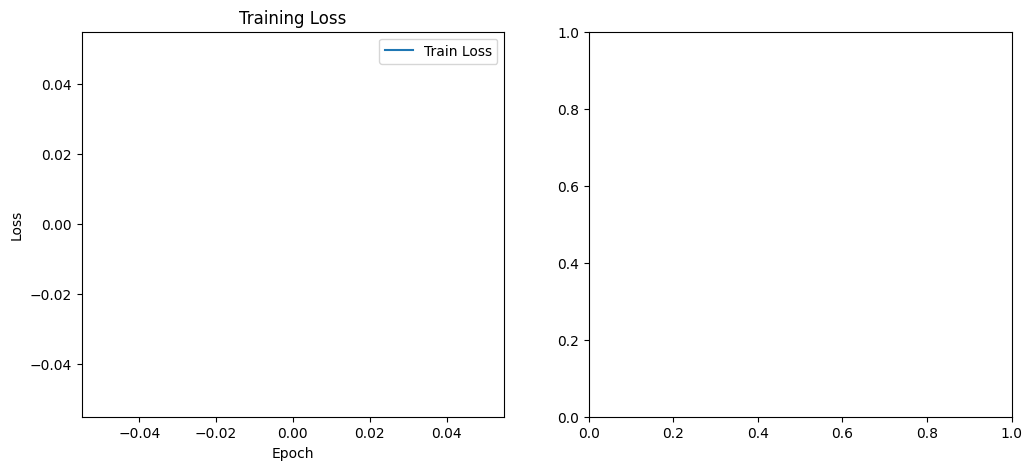

In [25]:
# 1. Historial de entrenamiento
plot_training_history(train_loss_history, val_metric_history)

# 2. Matrices de confusión (en validation set)
# plot_confusion_matrices(model, val_loader, class_maps)

# 3. Distribución de clases
# plot_class_distribution(train_dataset, class_maps)

# 4. Predicciones de ejemplo
# plot_sample_predictions(model, val_dataset)